# **Importing Package**
Importing dependencies

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as aug
import matplotlib.image as mpimg
import cv2
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

Split the path name and give sonly the name of the file

In [2]:
def getName(filePath):
  return filePath.split("/")[-1]

# **Reading Datasets**

I have imported training data from my google drive.  

In [3]:
def importDataInfo(path):
  columns = ["Center", "Left", "Right", "Steering", "Throttle", "Brake", "Speed"]
  data = pd.read_csv(os.path.join(path,"driving_log.csv"), names=columns)
  print(getName(data["Center"][0]))
  data["Center"] = data["Center"].apply(getName)
  print(data.head())
  return data

## Google Drive Path

In [4]:
path = "drive/MyDrive/data"
data = importDataInfo(path)

center_2022_01_21_16_31_12_631.jpg
                               Center  ...     Speed
0  center_2022_01_21_16_31_12_631.jpg  ...  0.000078
1  center_2022_01_21_16_31_12_732.jpg  ...  0.000079
2  center_2022_01_21_16_31_12_836.jpg  ...  0.000079
3  center_2022_01_21_16_31_12_939.jpg  ...  0.000080
4  center_2022_01_21_16_31_13_039.jpg  ...  0.000082

[5 rows x 7 columns]


# **Checking and Removing Baisedness**

Balancing the data for right and left steering 


In [5]:
def balanceBiased(data, display=True):
  nBins = 31
  samplesPerBin = 1000
  hist, bins = np.histogram(data['Steering'],nBins)
  if display:
    center = (bins[:-1] + bins[1:])*0.5
    plt.bar(center, hist, width = 0.06)
    plt.plot((-1,1), (samplesPerBin, samplesPerBin))
    plt.show()
  removeIndex = []
  for j in range(nBins):
    binDataList = []
    for i in range(len(data["Steering"])):
      if data["Steering"][i] >= bins[j] and data["Steering"][i] <= bins[j+1]:
        binDataList.append(i)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[samplesPerBin:]
    removeIndex.extend(binDataList)
  print("Removed Images: ", len(removeIndex)) 
  data.drop(data.index[removeIndex], inplace = True)
  print("Images Remains", len(data)) 
  if display:
    hist, _ = np.histogram(data['Steering'],nBins)
    plt.bar(center, hist, width = 0.06)
    plt.plot((-1,1), (samplesPerBin, samplesPerBin))
    plt.show()
  return data


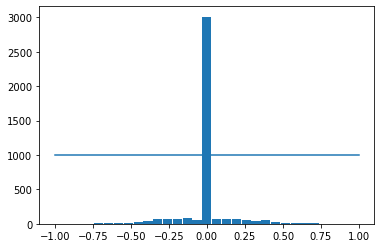

Removed Images:  2009
Images Remains 1878


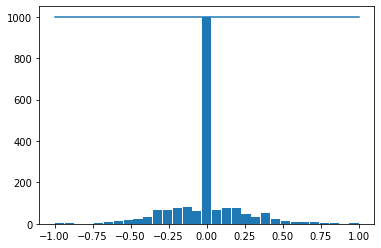

In [6]:
data = balanceBiased(data, display=True)

# **Appending Image from IMG Folder**

Converting images as an array

In [7]:
imagesPath = []
steering = []
for i in range(len(data)):
  indexData = data.iloc[i]
  imagesPath.append(os.path.join(path, "IMG", indexData[0]))
  steering.append(float(indexData[3]))
imagesPath = np.asarray(imagesPath)
steering = np.asarray(steering)

# **Spliting Datasets into Training and Validation** 

In [8]:
x_train, x_val, y_train, y_val = train_test_split(imagesPath, steering, test_size=0.2, random_state=5)

In [9]:
x_train.shape

(1502,)

# **Data Augmentation**

Image is fliped, Zoomed, Brightness 

In [10]:
def augmentImage(imgPath, steering):
  img = mpimg.imread(imgPath)
  if np.random.rand() < 0.5:
    pan = aug.Affine(translate_percent={'x': (-0.1,0.1),'y': (-0.1,0.1)})
    img = pan.augment_image(img)
  if np.random.rand() < 0.5:
    zoom = aug.Affine(scale=(1,1.2))
    img = zoom.augment_image(img)
  if np.random.rand() < 0.5:
    brightness = aug.Multiply((0.4,1.2))
    img = brightness.augment_image(img)
  if np.random.rand() < 0.5: 
    img = cv2.flip(img, 1)
    steering = -steering
  return img, steering

# **PreProcessing Image**

- Converting RGB Image into YUV 
- Adding Gaussian Blur
- Resizing Image


In [11]:
def preProcessing(img):
  img = img[60:135,:,:]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3),0)
  img = cv2.resize(img, (200,68))
  img = img / 255
  return img

# **Generating Batches**

This function is an python generator so it yeild instead of returning

In [12]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
  while True:
    imgBatch = []
    steeringBatch = []
    for i in range(batchSize):
      index = random.randint(0, len(imagesPath)-1)
      if trainFlag:
        img, steering = augmentImage(imagesPath[index], steeringList[index])
      else:
        img = mpimg.imread(imagesPath[index])  
        steering = steeringList[index]
      img = preProcessing(img)
      imgBatch.append(img)
      steeringBatch.append(steering)
    yield (np.asarray(imgBatch), np.asarray(steeringBatch))

# **Creating a Convolutional Neural Network Model**

In [16]:
model = Sequential()
model.add(Conv2D(24,(5,5),(2,2), input_shape=(66,200,3), activation="elu"))
model.add(BatchNormalization())
model.add(Conv2D(36,(5,5),(2,2) ,activation="elu"))
model.add(BatchNormalization())
model.add(Conv2D(48,(5,5), activation="elu"))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3), activation="elu"))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(100,activation='elu'))
model.add(Dense(50,activation='elu'))
model.add(Dense(10,activation='elu'))
model.add(Dense(1))
model.compile(Adam(learning_rate=0.001),loss = "mse")

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 31, 98, 24)        1824      
                                                                 
 batch_normalization_4 (Batc  (None, 31, 98, 24)       96        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 batch_normalization_5 (Batc  (None, 14, 47, 36)       144       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 43, 48)        43248     
                                                                 
 batch_normalization_6 (Batc  (None, 10, 43, 48)      

# **Fitting Into The Model**

In [18]:
history = model.fit(batchGen(x_train, y_train, 100, 1), steps_per_epoch=300, epochs=10, validation_data=batchGen(x_val, y_val, 100, 0), validation_steps=200)

Epoch 1/10
300/300 [==============================] - 330s 1s/step - loss: 0.6347 - val_loss: 0.0430
Epoch 2/10
300/300 [==============================] - 323s 1s/step - loss: 0.0528 - val_loss: 0.0355
Epoch 3/10
300/300 [==============================] - 327s 1s/step - loss: 0.0397 - val_loss: 0.0345
Epoch 4/10
300/300 [==============================] - 328s 1s/step - loss: 0.0342 - val_loss: 0.0325
Epoch 5/10
300/300 [==============================] - 326s 1s/step - loss: 0.0319 - val_loss: 0.0330
Epoch 6/10
300/300 [==============================] - 326s 1s/step - loss: 0.0293 - val_loss: 0.0346
Epoch 7/10
300/300 [==============================] - 325s 1s/step - loss: 0.0291 - val_loss: 0.0310
Epoch 8/10
300/300 [==============================] - 326s 1s/step - loss: 0.0279 - val_loss: 0.0323
Epoch 9/10
300/300 [==============================] - 327s 1s/step - loss: 0.0259 - val_loss: 0.0313
Epoch 10/10
300/300 [==============================] - 325s 1s/step - loss: 0.0252 - val_lo

# **Saving the Model**

Also Ploting the Training Loss and validation Loss

Model Saved


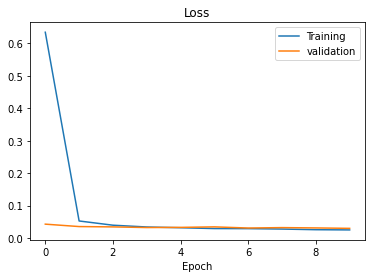

In [19]:
model.save("model.h5")
print("Model Saved")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'validation'])
plt.title('Loss')
plt.xlabel("Epoch")
plt.show()